In [139]:
import pandas as pd
import geopandas as gpd
import json
from shapely.ops import unary_union, nearest_points
from functools import reduce

In [140]:
sensors = gpd.read_file("iot_sensors/iot_sensors.shp")
sensors['id'] = sensors.index
sensors.head(5)

,id,type,geometry
0,0,None,POINT (18.95809 50.27747)
1,1,None,POINT (18.95605 50.27781)
2,2,None,POINT (18.95672 50.28115)
3,3,None,POINT (18.9554 50.28192)
4,4,None,POINT (18.9555 50.27869)


In [141]:
sensors_metric = sensors.to_crs(2180)
sensors_metric.head(5)

,id,type,geometry
0,0,None,POINT (497014.375 267811.545)
1,1,None,POINT (496869.185 267848.796)
2,2,None,POINT (496917.58 268220.048)
3,3,None,POINT (496823.269 268305.552)
4,4,None,POINT (496830.044 267947.391)


In [142]:
buildings = gpd.read_file("buildings/buildings.shp")
buildings.head(5)

,osm_id,code,fclass,name,type,geometry
0,51568880,1500,building,Kościół imienia księdza Marcina Lutra w Chorzowie,church,"POLYGON ((18.95158 50.29497, 18.95159 50.29498..."
1,130893698,1500,building,None,None,"POLYGON ((18.96017 50.28608, 18.96018 50.28609..."
2,162101759,1500,building,Netto,retail,"POLYGON ((18.93746 50.30218, 18.93777 50.30218..."
3,167522394,1500,building,None,None,"POLYGON ((18.96273 50.28429, 18.96241 50.284, ..."
4,167524233,1500,building,None,roof,"POLYGON ((18.95905 50.28278, 18.95925 50.2828,..."


In [143]:
buildings_metric = buildings.to_crs(2180)
buildings_metric.head(5)

,osm_id,code,fclass,name,type,geometry
0,51568880,1500,building,Kościół imienia księdza Marcina Lutra w Chorzowie,church,"POLYGON ((496552.236 269757.166, 496553.02 269..."
1,130893698,1500,building,None,None,"POLYGON ((497163.675 268768.031, 497164.374 26..."
2,162101759,1500,building,Netto,retail,"POLYGON ((495547.576 270558.779, 495569.156 27..."
3,167522394,1500,building,None,None,"POLYGON ((497345.382 268569.328, 497322.884 26..."
4,167524233,1500,building,None,roof,"POLYGON ((497083.117 268401.524, 497097.94 268..."


In [144]:
readings = pd.read_json(r"device_readings.json")
readings = readings.explode("readings",ignore_index = True)
readings = pd.concat([readings.drop(columns="readings"), pd.json_normalize(readings["readings"])],
    axis=1)
readings

,timestamp,sensor_id,distance_m
0,0,0,52.351086
1,0,1,130.976336
2,0,65,81.487977
3,1,0,56.522340
4,1,1,106.231487
...,...,...,...
1030,242,44,113.697227
1031,242,45,37.349685
1032,242,46,26.953882
1033,242,49,63.329263


In [145]:
temp = readings[readings['timestamp']==0]
temp
lokalizacje = pd.merge(temp,sensors_metric, left_on = "sensor_id", right_on = "id")
lokalizacje

,timestamp,sensor_id,distance_m,id,type,geometry
0,0,0,52.351086,0,None,POINT (497014.375 267811.545)
1,0,1,130.976336,1,None,POINT (496869.185 267848.796)
2,0,65,81.487977,65,None,POINT (496895.92 267780.7)


In [146]:
lokalizacje['buffer'] = lokalizacje.apply(lambda x: x.geometry.buffer(x['distance_m']), axis=1)
lokalizacje['granice'] = lokalizacje['buffer'].apply(lambda x: x.boundary)
lokalizacje

,timestamp,sensor_id,distance_m,id,type,geometry,buffer,granice
0,0,0,52.351086,0,None,POINT (497014.375 267811.545),POLYGON ((497066.72604479553 267811.5448085079...,LINESTRING (497066.72604479553 267811.54480850...
1,0,1,130.976336,1,None,POINT (496869.185 267848.796),POLYGON ((497000.1611639721 267848.79573319945...,LINESTRING (497000.1611639721 267848.795733199...
2,0,65,81.487977,65,None,POINT (496895.92 267780.7),POLYGON ((496977.4079066708 267780.70013144054...,LINESTRING (496977.4079066708 267780.700131440...


In [147]:


areas = [ln.buffer(0.05) for ln in lokalizacje['granice']]
common = reduce(lambda a,b: a.intersection(b), areas)
res = gpd.GeoDataFrame(geometry = [common.centroid], crs = sensors_metric.crs)
res.to_crs(4326)


,geometry
0,POINT (18.95756 50.27714)


In [218]:
df = pd.DataFrame(columns=['timestamp','sensors_id','crossing_point'])
for ts in readings['timestamp'].unique():
    #ustalanie pojedynczych punktow
    reading = readings[readings['timestamp']==ts]
    lokalizacje = pd.merge(reading,sensors_metric, left_on = "sensor_id", right_on = "id")

    #promien wokol sensorow
    lokalizacje['buffer'] = lokalizacje.apply(lambda x: x.geometry.buffer(x['distance_m']), axis=1)
    lokalizacje['granice'] = lokalizacje['buffer'].apply(lambda x: x.boundary)
    
    #punkty przeciecia
    areas = [ln.buffer(40) for ln in lokalizacje['granice']]
    common = reduce(lambda a,b: a.intersection(b), areas)
    res = gpd.GeoDataFrame(geometry = [common.centroid], crs = sensors_metric.crs)
    #res = res.to_crs(4326)

    #zapis
    temp = pd.DataFrame([{
        'timestamp'     : int(ts),
        'sensors_id'    : reading['sensor_id'].unique().tolist(),
        'crossing_point': res.geometry.iloc[0]
    }])
    df = pd.concat([df, temp],ignore_index=True)

243


<Axes: >

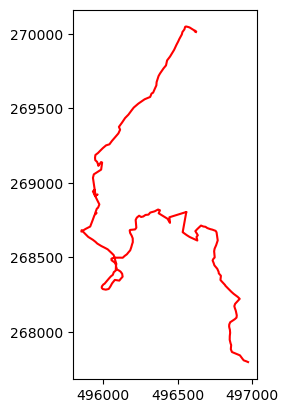

In [219]:
points = gpd.GeoDataFrame(df, geometry='crossing_point', crs = 2180)
points = points.sort_values('timestamp')
print(len(points[~points.geometry.is_empty]))
points = points[~points.geometry.is_empty].copy()
line = LineString(points.geometry.tolist())
line_gdf = gpd.GeoDataFrame(geometry=[line], crs=points.crs)
line_gdf.plot(color='red')

In [220]:
type(df['crossing_point'][0])

shapely.geometry.point.Point

In [221]:
df['crossing_point']

0        POINT (496977.5449802637 267794.0472504343)
1      POINT (496959.13130515354 267802.03946904815)
2        POINT (496942.2598550497 267808.2339058632)
3       POINT (496934.67729091935 267817.5282879748)
4       POINT (496916.5868559568 267841.89819603495)
                           ...                      
238     POINT (496620.43476501177 270012.2401299231)
239     POINT (496622.68933310657 270011.1290328317)
240      POINT (496624.5695476534 270010.1791972079)
241      POINT (496626.4730271979 270009.2799112625)
242    POINT (496627.84344843024 270008.44475453545)
Name: crossing_point, Length: 243, dtype: object

In [222]:
df.head(2)

,timestamp,sensors_id,crossing_point
0,0,"[0, 1, 65]",POINT (496977.5449802637 267794.0472504343)
1,1,"[0, 1, 65]",POINT (496959.13130515354 267802.03946904815)


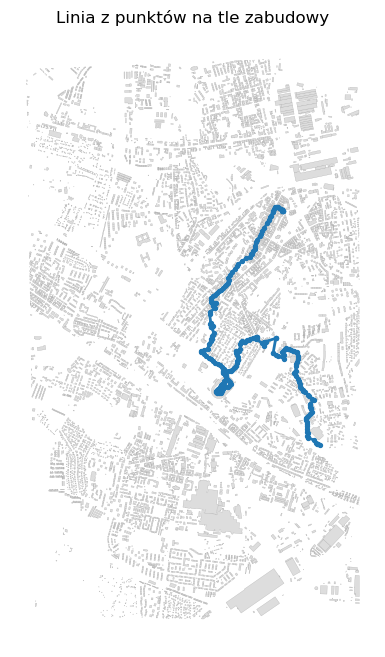

In [223]:
build_union = buildings_metric.dissolve().geometry.iloc[0]
b_union_gdf = gpd.GeoDataFrame(geometry=[build_union], crs=buildings_metric.crs)

#ax = b_union_gdf.plot(facecolor='#dddddd', edgecolor='#666666', linewidth=0.5, figsize=(8,8))
# ewentualnie zamiast union możesz narysować wszystkie budynki:
ax = buildings_metric.plot(facecolor='#dddddd', edgecolor='#aaaaaa', linewidth=0.2, figsize=(8,8))

# linia z punktów
line_gdf.plot(ax=ax, linewidth=2)

# (opcjonalnie) punkty wejściowe, jeśli chcesz je też pokazać
points.plot(ax=ax, markersize=8)

ax.set_title("Linia z punktów na tle zabudowy")
ax.set_axis_off()

In [224]:
b_union = buildings_metric['geometry'].union_all()

In [225]:
points["in_building"] = points.geometry.within(b_union)
print(len(points[points['in_building']==True]))
points[points['in_building']==True].head(3)

32


,timestamp,sensors_id,crossing_point,in_building
35,35,"[3, 53, 61]",POINT (496794.789 268337.661),True
36,36,"[3, 53, 61]",POINT (496785.942 268347.607),True
72,72,"[10, 8]",POINT (496460.812 268773.971),True


In [226]:
buildings_metric.head(2)

,osm_id,code,fclass,name,type,geometry
0,51568880,1500,building,Kościół imienia księdza Marcina Lutra w Chorzowie,church,"POLYGON ((496552.236 269757.166, 496553.02 269..."
1,130893698,1500,building,None,None,"POLYGON ((497163.675 268768.031, 497164.374 26..."


In [227]:
hits = gpd.sjoin(points, buildings_metric, how='left', predicate='within')
hits = hits.drop(columns=['index_right'])
hits = hits[hits['in_building']]
summary = (
    hits.groupby("osm_id")
        .agg(
            n_points=("timestamp", "size"),
            ts_list = ("timestamp", lambda s: list(sorted(s))),
            ts_min  = ("timestamp", "min"),
            ts_max  = ("timestamp", "max"),
            bclass  = ("fclass", "first"),
            btype   = ("type", "first"),
            name    = ("name", "first"),
        )
        .reset_index()
)
summary

,osm_id,n_points,ts_list,ts_min,ts_max,bclass,btype,name
0,1107051616,1,[201],201,201,building,commercial,Budynek handlowo-usługowy
1,179044883,7,"[233, 234, 235, 236, 237, 238, 239]",233,239,building,apartments,None
2,179045438,3,"[240, 241, 242]",240,242,building,None,None
3,179130285,1,[200],200,200,building,retail,None
4,179130324,1,[206],206,206,building,None,None
5,179130492,1,[198],198,198,building,apartments,None
6,179130663,1,[196],196,196,building,apartments,None
7,179130705,1,[205],205,205,building,apartments,None
8,179315686,1,[180],180,180,building,None,None
9,179315820,1,[177],177,177,building,None,None


In [228]:
hits.head(2)

,timestamp,sensors_id,crossing_point,in_building,osm_id,code,fclass,name,type
35,35,"[3, 53, 61]",POINT (496794.789 268337.661),True,183031325,1500.0,building,None,apartments
36,36,"[3, 53, 61]",POINT (496785.942 268347.607),True,183031325,1500.0,building,None,apartments


In [229]:
bld = buildings_metric[["osm_id", "geometry"]].set_index("osm_id")
hits["dist_to_edge"] = hits.apply(
    lambda r: r['crossing_point'].distance(bld.loc[r["osm_id"], "geometry"].boundary),
    axis=1,
)
hits.head(3)

,timestamp,sensors_id,crossing_point,in_building,osm_id,code,fclass,name,type,dist_to_edge
35,35,"[3, 53, 61]",POINT (496794.789 268337.661),True,183031325,1500.0,building,None,apartments,0.608431
36,36,"[3, 53, 61]",POINT (496785.942 268347.607),True,183031325,1500.0,building,None,apartments,1.663692
72,72,"[10, 8]",POINT (496460.812 268773.971),True,225545618,1500.0,building,None,None,0.451059


In [230]:
def snap_to_boundary(pt, poly):
    return nearest_points(pt, poly.boundary)[1]

hits["fixed_point"] = hits.apply(
    lambda r: (
        snap_to_boundary(r["crossing_point"], bld.loc[r["osm_id"], "geometry"])
        if pd.notna(r["osm_id"]) else r["crossing_point"]
    ),
    axis=1
)

In [231]:
hits.head(2)

,timestamp,sensors_id,crossing_point,in_building,osm_id,code,fclass,name,type,dist_to_edge,fixed_point
35,35,"[3, 53, 61]",POINT (496794.789 268337.661),True,183031325,1500.0,building,None,apartments,0.608431,POINT (496795.299 268337.329)
36,36,"[3, 53, 61]",POINT (496785.942 268347.607),True,183031325,1500.0,building,None,apartments,1.663692,POINT (496786.859 268348.995)


In [232]:
points.head(2)

,timestamp,sensors_id,crossing_point,in_building
0,0,"[0, 1, 65]",POINT (496977.545 267794.047),False
1,1,"[0, 1, 65]",POINT (496959.131 267802.039),False


In [233]:
hits = hits[['timestamp','fixed_point']]
points = points.merge(hits, on="timestamp", how="left", suffixes=("", "_new"))
points["crossing_point"] = points["fixed_point"].combine_first(points["crossing_point"])
points.drop(columns=["fixed_point",'in_building','sensors_id'],inplace=True)


<Axes: >

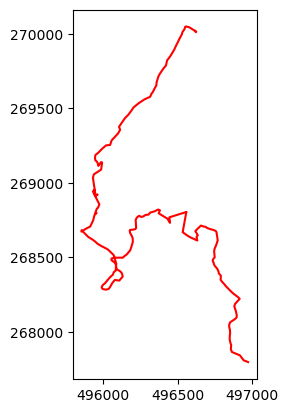

In [234]:

line = LineString(points.crossing_point.tolist())
line_gdf = gpd.GeoDataFrame(geometry=[line], crs=points.crs)
line_gdf.plot(color='red')

In [235]:
points.head(2)

,timestamp,crossing_point
0,0,POINT (496977.545 267794.047)
1,1,POINT (496959.131 267802.039)


In [236]:
points.set_geometry('crossing_point')
points.set_crs(2180)
points.to_crs(4326)
records = [
    {
        "timestamp": int(row["timestamp"]),
        "position": {
            "lat": row.crossing_point.y,
            "lon": row.crossing_point.x,
        },
    }
    for _, row in points.iterrows()
]
with open("points.json", "w", encoding="utf-8") as f:
    json.dump(records, f, ensure_ascii=False, indent=2)

In [237]:
points = points.to_crs(4326)
points.to_csv("punkty.csv",index=False)